# 推荐系统实战-3

## 隐语义模型实战

使用 [Text8](http://mattmahoney.net/dc/textdata) 数据集训练word2vec

1. 安装依赖库

In [1]:
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import urllib
import zipfile

from matplotlib import pylab
from sklearn.manifold import TSNE
print('check: libs well prepared')

check: libs well prepared


2. 下载数据并解压

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    # 判断文件是否存在
    if not os.path.exists(filename):
        # 下载
        print('download...')
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
        
    # 校验大小
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print('exception %s' % statinfo.st_size)
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [5]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


3. 编码并替换低频次

In [7]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    # 每个词出现的次数
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    # 单词到数字的映射
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    # 数字到单词的映射
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

# 映射之后的训练数据
data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('original data', words[:10])
print('training data', data[:10])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
original data ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
training data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


4. 生成skip-gram训练数据

In [34]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # context word
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        # 循环使用
        data_index = (data_index + 1) % len(data)
    
    for i in range(batch_size // num_skips):
        target = skip_window  # 目标，当前词
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]  # 参考词
            labels[i * num_skips + j, 0] = buffer[target]  # 预测词
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

# data是给定语料，用buffer作为大小span（2*skip_window+1）的窗口扫描data去抽样
# target是skip-gram算法的中间词，通过循环取出num_skips个左右skip_window内的欲预测周围词
# 被预测词存到batch中，欲预测词存到labels中
print('data:', [reverse_dictionary[di] for di in data[:8]])
data_index = 0
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=2)
print('     batch:', [reverse_dictionary[bi] for bi in batch])
print('     labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
     batch: ['as', 'as', 'a', 'a', 'term', 'term', 'of', 'of']
     labels: ['originated', 'a', 'as', 'of', 'of', 'abuse', 'abuse', 'term']


5. 定义网路结构

In [45]:
batch_size = 128  # batch size
embedding_size = 128  # word embedding size
skip_window = 1  # context skip window(one side)
num_skips = 2  # num of predicted word in context
valid_size = 16  # 采样数量
valid_window = 100  # 查看训练效果的窗口
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64

graph = tf.Graph()\

with graph.as_default(), tf.device('/cpu:0'):
    # 输入数据
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # 定义变量
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                      stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # 本次训练数据对应的embedding
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)  # 128x128
    # neg softmax batch loss
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases,
                                                     inputs=embed, labels=train_labels,
                                                     num_sampled=num_sampled, num_classes=vocabulary_size))
    # 优化loss，更新参数
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
    # 归一化
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))  # 50000x1
    normalized_embeddings = embeddings / norm  # 50000x128
    # 用已有embedding计算valid的相似性
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)  # 16x128
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))  # 16x50000

6. 运行训练流程

In [46]:
num_steps = 100000

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    average_loss = 0
    
    for step in range(num_steps + 1):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, l = sess.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        # 每2000次打印loss
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # 每10000次打印valid效果
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):  # 16
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 5  # 取出相似度最高的top 5个词
                nearest = (-sim[i, :]).argsort()[1:top_k+1]  # argsort()[0]是valid_word词本身
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,'  % (log, close_word)
                print(log)
        final_embeddings = normalized_embeddings.eval()

Average loss at step 0: 7.622597
Nearest to after: chronica, invent, ken, tleilax, war,
Nearest to such: iona, forays, valery, paulist, calibrated,
Nearest to many: writs, seventy, turbojet, tuareg, sandworm,
Nearest to the: instituto, incrementing, deneb, eridu, passive,
Nearest to with: aino, basin, sounds, usp, preamble,
Nearest to years: ballot, vegetable, bluegrass, insulators, extraneous,
Nearest to only: raeder, vance, danorum, amhara, aroused,
Nearest to other: micrometres, usd, conclave, blitzkrieg, mad,
Nearest to had: norton, guerrero, generated, emulation, mgh,
Nearest to states: unfriendly, icy, tempered, restroom, penetration,
Nearest to at: airships, alloy, chronic, bits, corrects,
Nearest to in: youth, haka, sophisticated, bind, durst,
Nearest to most: christological, madero, wanderer, forefathers, ashby,
Nearest to than: necessitated, nairobi, artistically, function, accountability,
Nearest to their: hizbullah, tell, imperial, jump, uf,
Nearest to see: sephardim, pius,

Nearest to states: kingdom, atoll, pretoria, canossa, situation,
Nearest to at: with, on, from, and, of,
Nearest to in: of, on, and, by, from,
Nearest to most: maclachlan, use, gormenghast, music, dialect,
Nearest to than: sufficed, performance, pleasing, mpg, scrupulous,
Nearest to their: the, his, both, cheng, its,
Nearest to see: is, gita, freas, downloadable, hallertau,
Average loss at step 72000: 4.898590
Average loss at step 74000: 4.963731
Average loss at step 76000: 5.011520
Average loss at step 78000: 5.077323
Average loss at step 80000: 5.134045
Nearest to after: over, until, in, olav, was,
Nearest to such: described, keynesian, arithmetical, various, hummer,
Nearest to many: mjt, anil, supergravity, flunitrazepam, manual,
Nearest to the: a, this, their, any, an,
Nearest to with: from, in, for, of, dwan,
Nearest to years: vt, na, mindat, lder, cordilleras,
Nearest to only: micro, macrovision, it, counterfactual, gunmen,
Nearest to other: mithraic, interquartile, gaudy, surrep

7. 可视化

In [48]:
num_points = 400  # 可视化400个点
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

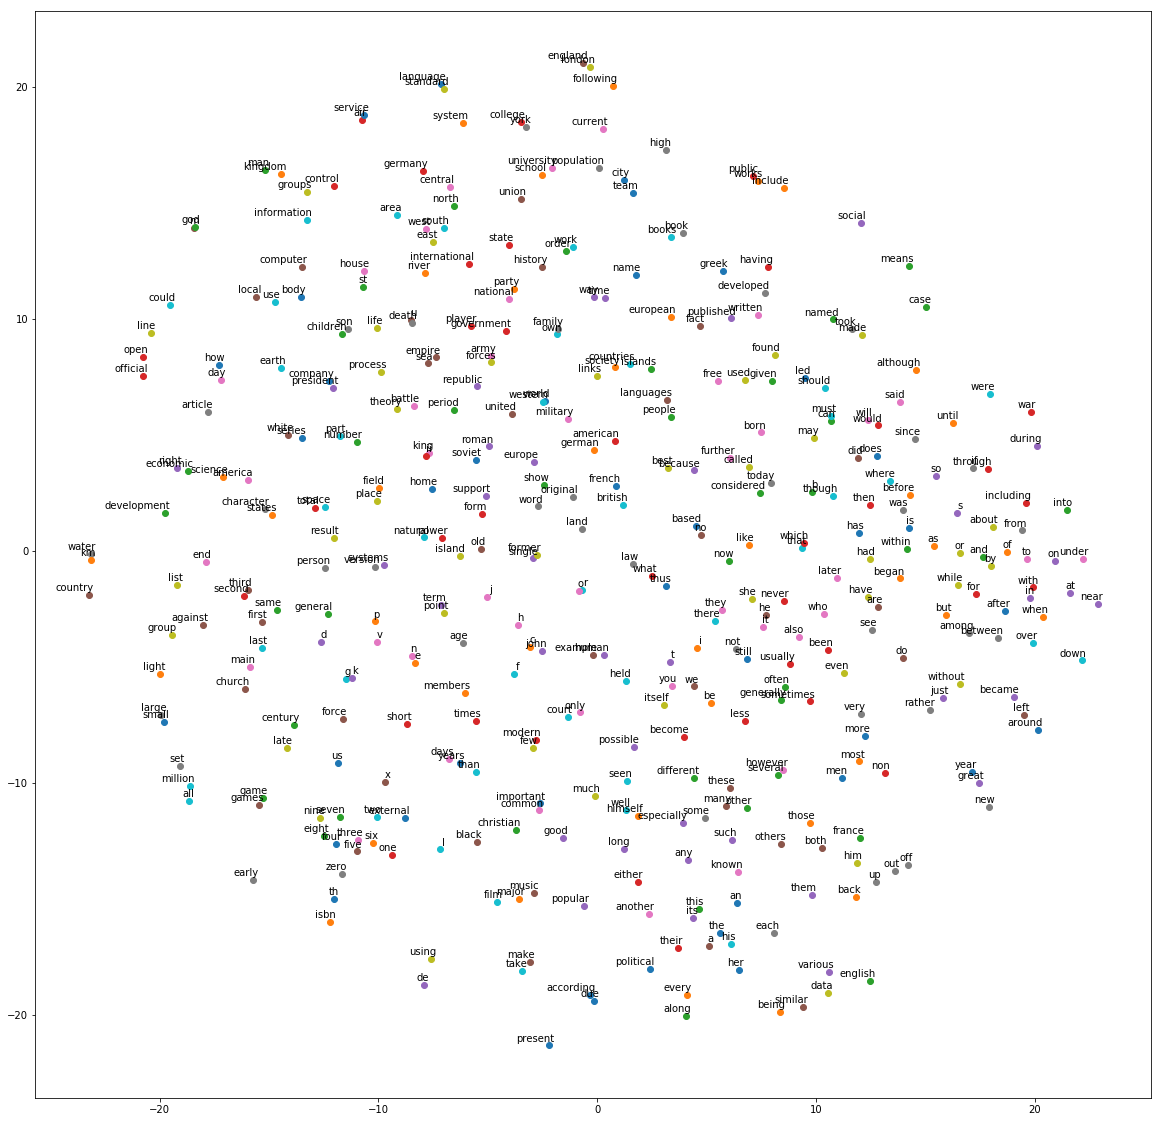

In [50]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(20, 20))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    pylab.show()
words = [reverse_dictionary[i] for i in range(1, num_points + 1)]
plot(two_d_embeddings, words)